In [ ]:
# !pip install pandas
# !pip install tensorflow

# CNN RNN
По этому примеру: https://huggingface.co/keras-io/video-classification-cnn-rnn/blob/main/main.ipynb

In [42]:
from tensorflow import keras

import pandas as pd
import numpy as np
import os
import cv2
from datetime import datetime
from pathlib import Path
import imageio

2023-10-20 20:39:41.660726: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-20 20:39:41.707444: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-20 20:39:42.540111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [61]:
annotations_path = 'SLOVO_DATAFRAME.tsv'
video_path = 'animals'
current_dir = os.getcwd()

IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 12

MAX_SEQ_LENGTH=20
NUM_FEATURES=2048

In [44]:
annot_df = pd.read_csv(annotations_path, sep='\t')
annot_df.head()

,attachment_id,text,user_id,height,width,length,begin,end
0,44e8d2a0-7e01-450b-90b0-beb7400d2c1e,Ё,185bd3a81d9d618518d10abebf0d17a8,640,360,156.0,36,112
1,df5b08f0-41d1-4572-889c-8b893e71069b,А,185bd3a81d9d618518d10abebf0d17a8,640,360,150.0,36,76
2,17f53df4-c467-4aff-9f48-20687b63d49a,Р,185bd3a81d9d618518d10abebf0d17a8,640,360,133.0,40,97
3,e3add916-c708-4339-ad98-7e2740be29e9,Е,185bd3a81d9d618518d10abebf0d17a8,640,360,144.0,43,107
4,bd7272ed-1850-48f1-a2a8-c8fed523dc37,Ч,185bd3a81d9d618518d10abebf0d17a8,640,360,96.0,20,70


In [45]:
# Возьмем для начала уменьшенный датасет из 30 животных и поделим датасет на train и test
selected_animals = [
    'пингвин','жираф', 'лягушка', 'бегемот', 'козел',
    'лиса', 'динозавр', 'кролик', 'собака', 'обезьяна',
    'корова', 'свинья', 'медуза', 'курица', 'павлин',
    'дельфин', 'слон', 'медведь', 'лебедь', 'орел',
    'бык', 'змея', 'птица', 'лось', 'пчела',
    'лев', 'тигр', 'мышь', 'паук', 'бабочка'
    ]
train_df = pd.DataFrame(columns=['attachment_id', 'text', 'begin', 'end'])
test_df = pd.DataFrame(columns=['attachment_id', 'text', 'begin', 'end'])
for animal in selected_animals:
    train_df = pd.concat([train_df, annot_df[annot_df.text==animal][['attachment_id', 'text', 'begin', 'end']][:18]], ignore_index=True)
    test_df = pd.concat([test_df, annot_df[annot_df.text==animal][['attachment_id', 'text', 'begin', 'end']][18:]], ignore_index=True)
    
test_df.head(8)
    

,attachment_id,text,begin,end
0,e61c12a9-f727-441d-86e8-a9b854decd3e,пингвин,32,111
1,2eca9c1e-103c-4a23-98c8-1e994fe76762,пингвин,18,65
2,78c4c85b-5b75-42e7-bf3b-ee323b05c573,жираф,62,126
3,8ee72ac2-cd61-4995-93eb-4e9e5a43f873,жираф,15,56
4,a912411f-d2b8-46f3-9741-c326897a08c8,лягушка,5,55
5,98eedd68-135e-498e-9704-3cde2655a480,лягушка,10,61
6,2fe89f0b-eb56-4225-865d-3f55cf9059be,бегемот,28,109
7,2e133e33-aff4-44c1-b8f0-30ae2cdb03b7,бегемот,24,75


In [53]:
# The following two methods are taken from this tutorial:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub


def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]


def load_video(path, begin, end, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    flipped_frames = []
    frame_index=begin
    try:
        while True and frame_index <= end:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
            frame = Concatenate()([frame, frame, frame]) 
            #frame = frame[:, :, [2, 1, 0]] # not needed for grayscale
            frames.append(frame)
            flipped_frame = cv2.flip(frame, 1)
            flipped_frames.append(flipped_frame)
            frame_index+=1

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames), np.array(flipped_frames)

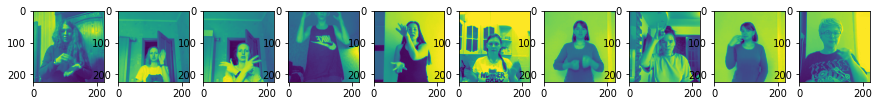

In [54]:
# Check how random videos are cropped
def load_frame(path, frame_index, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    try:
        while True:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # convert to grayscale
            break
    finally:
        cap.release()
    return frame
import random
import matplotlib.pyplot as plt
test_videos = random.choices(test_df["attachment_id"].values.tolist(), k = 10)
middle_frames = [int((int(test_df[test_df.attachment_id==test_video]['begin']) + int(test_df[test_df.attachment_id==test_video]['end']))/2) for test_video in test_videos]
test_video_paths = [f"{video_path}/{test_video}.mp4" for test_video in test_videos]
frames = [load_frame(test_video_path, middle_frame) for test_video_path, middle_frame in zip(test_video_paths, middle_frames)]

n = len(frames)
f, axarr = plt.subplots(1,n)
f.set_figheight(5)
f.set_figwidth(15)
for i in range(n):
    axarr[i].imshow(frames[i])

In [47]:
def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

2023-10-20 20:40:06.952986: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [48]:
label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df["text"])
)
print(label_processor.get_vocabulary())

['бабочка', 'бегемот', 'бык', 'дельфин', 'динозавр', 'жираф', 'змея', 'козел', 'корова', 'кролик', 'курица', 'лебедь', 'лев', 'лиса', 'лось', 'лягушка', 'медведь', 'медуза', 'мышь', 'обезьяна', 'орел', 'павлин', 'паук', 'пингвин', 'птица', 'пчела', 'свинья', 'слон', 'собака', 'тигр']


In [55]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)*2
    video_paths = df["attachment_id"].values.tolist()
    begins = df["begin"].values.tolist()
    ends =df["end"].values.tolist()
    labels = df["text"].values
    labels = np.repeat(labels,2,0)
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames, flipped_frames = load_video(''.join([root_dir, path, '.mp4']), begin=begins[idx], end=ends[idx])
        frames = frames[None, ...]
        flipped_frames = flipped_frames[None, ...]
        
        def temp_features(frames):
            # Initialize placeholders to store the masks and features of the current video.
            temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
            temp_frame_features = np.zeros(
                shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
            )
            # Extract features from the frames of the current video.
            for i, batch in enumerate(frames):
                video_length = batch.shape[0]
                length = min(MAX_SEQ_LENGTH, video_length)
                for j in range(length):
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )
                temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked
            return temp_frame_features, temp_frame_mask
        
        temp_frame_features, temp_frame_mask = temp_features(frames)
        frame_features[idx*2,] = temp_frame_features.squeeze()
        frame_masks[idx*2,] = temp_frame_mask.squeeze()
        
        temp_frame_features, temp_frame_mask = temp_features(flipped_frames)
        frame_features[idx*2+1,] = temp_frame_features.squeeze()
        frame_masks[idx*2+1,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels


train_data, train_labels = prepare_all_videos(train_df, video_path)
test_data, test_labels = prepare_all_videos(test_df, video_path)

print(f"Frame features in train set: {train_data[0].shape}")
print(f"Frame masks in train set: {train_data[1].shape}")

Frame features in train set: (1080, 20, 2048)
Frame masks in train set: (1080, 20)


In [56]:
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
    )
    return rnn_model

logdir = f"logs/scalars/{datetime.now().strftime('%Y%m%d-%H%M%S')}/"
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

def run_experiment():
    filepath = Path.cwd()
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        batch_size=BATCH_SIZE,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[
            checkpoint,
            tensorboard_callback,
        ],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history, seq_model

In [57]:
history, sequence_model = run_experiment()

Epoch 1/12
10/12 [========================>.....] - ETA: 0s - loss: 3.3994 - accuracy: 0.0328  
Epoch 1: val_loss improved from inf to 3.41370, saving model to /home/jupyter/work/resources
12/12 [==============================] - 8s 192ms/step - loss: 3.3990 - accuracy: 0.0317 - val_loss: 3.4137 - val_accuracy: 0.0000e+00
Epoch 2/12
10/12 [========================>.....] - ETA: 0s - loss: 3.3939 - accuracy: 0.0344
Epoch 2: val_loss did not improve from 3.41370
12/12 [==============================] - 0s 29ms/step - loss: 3.3936 - accuracy: 0.0331 - val_loss: 3.4263 - val_accuracy: 0.0000e+00
Epoch 3/12
10/12 [========================>.....] - ETA: 0s - loss: 3.3887 - accuracy: 0.0437
Epoch 3: val_loss did not improve from 3.41370
12/12 [==============================] - 0s 30ms/step - loss: 3.3884 - accuracy: 0.0410 - val_loss: 3.4389 - val_accuracy: 0.0000e+00
Epoch 4/12
10/12 [========================>.....] - ETA: 0s - loss: 3.3836 - accuracy: 0.0328
Epoch 4: val_loss did not improv

In [59]:
def prepare_single_video(frames):
    frames = frames[None, ...]
    frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
        frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

    return frame_features, frame_mask


def sequence_prediction(path, begin, end):
    class_vocab = label_processor.get_vocabulary()

    frames, flipped_frames = load_video(os.path.join("test", path), begin, end)
    frame_features, frame_mask = prepare_single_video(frames)
    probabilities = sequence_model.predict([frame_features, frame_mask])[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["attachment_id"].values.tolist())
begin = int(test_df[test_df.attachment_id==test_video]['begin'])
end = int(test_df[test_df.attachment_id==test_video]['end'])
test_video_path = f"animals/{test_video}.mp4"
print(f"Test video path: {test_video_path}")
test_frames = sequence_prediction(test_video_path, begin, end)
#to_gif(test_frames[:MAX_SEQ_LENGTH])

Test video path: animals/4967d8f6-91f1-45a5-9133-14000439f991.mp4
1/1 [==============================] - 2s 2s/step
  кролик:  3.36%
  обезьяна:  3.36%
  лебедь:  3.36%
  собака:  3.36%
  бык:  3.36%
  пингвин:  3.36%
  козел:  3.35%
  курица:  3.35%
  лиса:  3.35%
  орел:  3.35%
  медуза:  3.35%
  павлин:  3.35%
  динозавр:  3.35%
  жираф:  3.35%
  бегемот:  3.35%
  медведь:  3.35%
  слон:  3.35%
  свинья:  3.35%
  корова:  3.34%
  дельфин:  3.34%
  лягушка:  3.34%
  змея:  3.29%
  тигр:  3.29%
  лось:  3.29%
  лев:  3.29%
  мышь:  3.29%
  паук:  3.29%
  птица:  3.29%
  пчела:  3.29%
  бабочка:  3.29%


In [60]:
test_df[test_df.attachment_id==test_video]

,attachment_id,text,begin,end
29,4967d8f6-91f1-45a5-9133-14000439f991,павлин,42,141
